/Users/sueszli/.asdf/installs/python/3.11.9/lib/python3.11/site-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size'
  return func(*args, **kwargs)


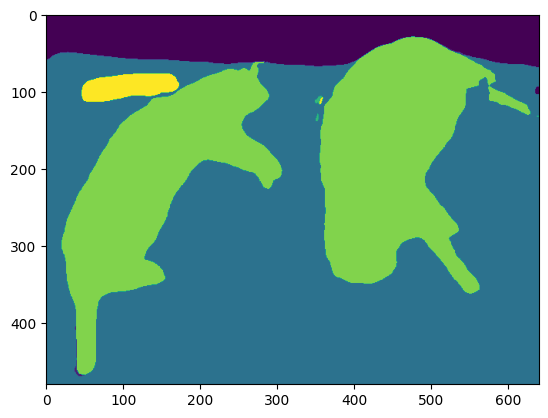

In [7]:
import requests
import torch
from PIL import Image
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation


# load Mask2Former fine-tuned on ADE20k semantic segmentation
processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-ade-semantic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-ade-semantic")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
inputs = processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

# model predicts class_queries_logits of shape `(batch_size, num_queries)`
# and masks_queries_logits of shape `(batch_size, num_queries, height, width)`
class_queries_logits = outputs.class_queries_logits
masks_queries_logits = outputs.masks_queries_logits

# you can pass them to processor for postprocessing
predicted_semantic_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
# we refer to the demo notebooks for visualization (see "Resources" section in the Mask2Former docs)

import matplotlib.pyplot as plt
plt.imshow(predicted_semantic_map)
plt.show()

update: you have to import the labels of the train set - this essentially renders this model useless.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import requests
from PIL import Image

labels = ["cat", "remote control"]

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
img = Image.open(requests.get(url, stream=True).raw)


from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation

model_id = "facebook/mask2former-swin-large-ade-semantic"
processor = AutoImageProcessor.from_pretrained(model_id)
model = Mask2FormerForUniversalSegmentation.from_pretrained(model_id)

inputs = processor(images=img, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)
predicted_semantic_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[img.size[::-1]])[0]
# get labels for each mask

# Get unique labels and their counts
unique_labels, label_counts = torch.unique(predicted_semantic_map, return_counts=True)

# Sort labels by count (descending order)
sorted_indices = torch.argsort(label_counts, descending=True)
sorted_labels = unique_labels[sorted_indices]

# Get the top 2 most common labels (excluding background)
top_labels = sorted_labels[1:3]  # Assuming 0 is background

# Create a color map for visualization
color_map = plt.cm.get_cmap('tab20')

# Create a masked image
masked_image = np.array(img)
for i, label in enumerate(top_labels):
    mask = predicted_semantic_map == label
    color = np.array(color_map(i / len(top_labels)))[:3]
    masked_image[mask.numpy()] = (masked_image[mask.numpy()] * 0.5 + color * 255 * 0.5).astype(np.uint8)

# Visualize the result
plt.figure(figsize=(10, 10))
plt.imshow(masked_image)
plt.axis('off')

# Add legend
for i, label in enumerate(top_labels):
    color = color_map(i / len(top_labels))
    # don't get id, get label
    plt.plot([], [], color=color, label=f"Label {label.item()}")

plt.legend()
plt.title("Semantic Segmentation")
plt.show()

# Print the top labels
print("Top labels:", top_labels.tolist())

